# Маркетинговый анализ приложения Procrastinate Pro+

**Заказчик** - маркетинговый отдел владельца развлекательного приложения Procrastinate Pro+ \
**Цель проекта** - проанализировать расходы на рекламу, определить их эффективность, найти точки роста \
**Основные шаги**:
- Построить рейтинги стран, устройств и рекламных источников по привлечению покупающих клиентов 
- Посчитать общие расходы на рекламу для каждого источника трафика и стоимость привлечения одного пользователя
- Посчитать окупаемость рекламы (метрики LTV, CAC и ROI) в разрезе устройств, стран, каналов привлечения
- Посчитать конверсию и удержание в разрезе устройств, стран, каналов привлечения

**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

User Id — уникальный идентификатор пользователя\
Device — категория устройства пользователя\
Session start — дата и время начала сессии\
Session End — дата и время окончания сессии\
Channel — идентификатор рекламного источника, из которого пришел пользователь\
Region - страна пользователя\

Таблица orders_log_short (информация о заказах):\

User Id — уникальный id пользователя, который сделал заказ\
Event Dt — дата и время покупки\
Revenue — выручка\

Таблица costs_short (информация о затратах на маркетинг):\

Channel — идентификатор рекламного источника\
Dt — дата\
Costs — затраты на этот рекламный источник в этот день\

## Загрузка и предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# отключаем предупреждения
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# выгружаем данные в переменные
df_visits = pd.read_csv('/datasets/visits_info_short.csv')
df_orders = pd.read_csv('/datasets/orders_info_short.csv')
df_costs = pd.read_csv('/datasets/costs_info_short.csv')

In [4]:
# сохраняю все таблицы в одну переменную, чтобы удобнее провести предобработку
data = [df_visits, df_orders, df_costs]
data_name = ['df_visits', 'df_orders', 'df_costs']

In [5]:
# смотрим на первые пять строк и инфо всех таблиц чтобы оценить пропуски и корректность типов данных
for i in range(len(data)):
    display(data_name[i])
    display(data[i].head(), data[i].info())
    print( )

'df_visits'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


None

'df_orders'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


None

'df_costs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


None

Пропусков в таблицах нет, стоит унифицировать наименования столбцов, привести столбцы с датами к типу даты. В остальном тип столбцов соответствует содержимому.

### Переименование, преобразование типов, дубликаты

In [6]:
# приводим к нижнему регистру и заменяем пробелы на нижнее подчеркивание
for d in data:
    d.columns = [x.lower().replace(' ', '_') for x in d.columns.values]

In [7]:
# преобразуем даты
for df in data:
    for col in df.columns:
        if 'session' in col or 'dt' in col:
            df[col] = pd.to_datetime(df[col])
            if col == 'dt':
                df[col]  = pd.to_datetime(df[col]).dt.date

In [8]:
# проверяем количество дубликатов в таблицах
for df in data:
    print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


### Проверка на артефакты

In [9]:
# смотрим как распределены значения числовых столбцов, чтобы проверить есть ли ошибки
for df in data:
    display(df.describe())

,user_id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


Отрицательных или нетипичных значений нет. Все нормально.

In [10]:
# смотрим уникальные значения категориальных столбцов на предмет ошибок
for i in range(len(data)):
    for col in data[i].select_dtypes(include=['object']).columns:
        if not 'dt' in col:            
            display('Таблица {}, уникальные значения столбца {}:'.format(data_name[i], col))
            display(data[i][col].unique()) 
            print('---------------------------')

'Таблица df_visits, уникальные значения столбца region:'

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

---------------------------


'Таблица df_visits, уникальные значения столбца device:'

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

---------------------------


'Таблица df_visits, уникальные значения столбца channel:'

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

---------------------------


'Таблица df_costs, уникальные значения столбца channel:'

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

---------------------------


Названия не дублируются, не повторяются. Ошибок нет.

In [11]:
# смотрим диапазон дат в таблицах, чтобы исключить ошибки
for i in range(len(data)):
    for col in data[i].select_dtypes(include=['object', 'datetime']).columns:
        if 'dt' in col or 'session' in col:
            display('В таблице {} в столбце {} диапазон дат от {} до {}'.format(data_name[i], col, data[i][col].min(), data[i][col].max()))    

'В таблице df_visits в столбце session_start диапазон дат от 2019-05-01 00:00:41 до 2019-10-31 23:59:23'

'В таблице df_visits в столбце session_end диапазон дат от 2019-05-01 00:07:06 до 2019-11-01 01:38:46'

'В таблице df_orders в столбце event_dt диапазон дат от 2019-05-01 00:28:11 до 2019-10-31 23:56:56'

'В таблице df_costs в столбце dt диапазон дат от 2019-05-01 до 2019-10-27'

Даты в пределах ожидаемого.

**Итого:**  Дубликатов и пропусков в данных нет. Артефактов, ошибок не нашли. Привели все наименования столбцов к нижнему регистру, даты к формату дата.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции для расчетов.

### Функция для расчета удержания

Чтобы посчитать удержание, нам нужно будет посчитать количество уникальных пользователей на основе данных из таблицы `df_visits`. Создадим функцию для определения первого посещения.

In [12]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

       # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
# проверим работоспособность
profiles = get_profiles(df_visits, df_orders, df_costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


В таблице уникальных пользователей получилось 150 тысяч записей.  
В столбце `dt` зафиксирована дата первого посещения,  
в столбце `channel` канал первого посещения,  
в столбце `payer` - стал ли этот посетитель в дальнейшем покупателем и  
в столбце `acquisition_cost` - цена привлечения посетителя определенного канала в эту дату.

**Функция для расчета удержания**

In [14]:
# функция для расчёта удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные 
    return result_raw, result_grouped, result_in_time

Проверим работоспособность.

In [15]:
# зададим момент анализа как последнюю дату из таблицы посещений
observation_date = df_visits['session_start'].max().date()
display(observation_date)
# создаём опцию «игнорировать горизонт»
ignore_horizon = False
# зададим горизон анализа данных
horizon_days = 14

datetime.date(2019, 10, 31)

In [16]:
# применяем функцию
retention_raw, retention, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, ignore_horizon=False)

In [17]:
# выводим результат
display(retention_raw.head())
retention

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,session_start,lifetime
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:58:57,0
1,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-08 06:00:42,0
2,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-09 07:33:16,1
3,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,2019-07-09 12:46:07,0
4,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,2019-07-10 22:27:24,1


,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,133348,1.0,0.176891,0.086226,0.051519,0.034496,0.024470,0.018418,0.014023,0.011774,0.009509,0.007739,0.006599,0.005894,0.004604
True,8361,1.0,0.404736,0.316589,0.259778,0.226887,0.209305,0.188375,0.173424,0.162421,0.150939,0.149743,0.136826,0.133596,0.122354


В нулевой день показатель удержания = 1, как и должно быть. Можно дополнительно проверить работу функции.

Проверим совпадает ли размер когорт в таблице удержания и число новых клиентов в эти даты, а также количество клиентов в когортах платящих пользователей и число покупателей за этот период.

In [18]:
# определим даты таблицы `retention_raw`
display(retention_raw['dt'].min())
retention_raw['dt'].max()

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 18)

In [19]:
# сумма размеров когорт равна числу новых клиентов в изучаемый период?

report = profiles.query(
     # в профилях находим пользователей, привлечённых за период таблицы retention_raw
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 18).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), retention['cohort_size'].sum()
    )
)

# сумма размеров платящих когорт равна числу покупателей в изучаемый период?

report = profiles.query(
    # в профилях находим платящих пользователей, привлечённых в наши даты
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 18).date() and payer == True'
)
print(
    # считаем уникальных платящих пользователей в профилях 
    # и складываем размеры платящих когорт
    'Общее количество новых покупателей: {} {}'.format(
        len(report['user_id'].unique()),
        retention.query('payer == True')['cohort_size'].sum(),
    )  
)

Общее количество новых пользователей: 141709 141709
Общее количество новых покупателей: 8361 8361


Проверка прошла успешно количество пользователей и покупателей совпадает, значит функция работает корректно.

### Функция для расчета конверсии

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Проверим работоспособность функции, задав параметры: 
- таблицу с профилями пользователей - profiles, 
- таблицу с заказами - df_orders,
- момент анализа - 31.10.2019 - последняя дата в наших данных,
- горизонт анализа - 14 дней и
- список dimensions оставим пустым,
- параметр ignore_horizon - оставим по умолчанию.

In [21]:
# применяем функцию
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, df_orders, datetime(2019, 10, 31).date(), 14)

In [22]:
# выводим результат
conversion_raw.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,event_dt,lifetime,cohort
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09,0.0,All users
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,NaT,NaN,All users
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,NaT,NaN,All users
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,NaT,NaN,All users
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,NaT,NaN,All users


In [23]:
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,141709,0.040901,0.046694,0.049496,0.051486,0.052939,0.053857,0.05464,0.055353,0.055903,0.056418,0.056701,0.056934,0.057096,0.057322


Предварительно можно сказать, что конверсия в покупателя за последние две недели в районе 4-5%.

In [24]:
conversion_history.head()

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
dt,,,,,,,,,,,,,,,
2019-05-01,909,0.031903,0.036304,0.038504,0.038504,0.040704,0.040704,0.040704,0.041804,0.042904,0.044004,0.044004,0.044004,0.044004,0.045105
2019-05-02,758,0.029024,0.035620,0.036939,0.036939,0.036939,0.036939,0.036939,0.038259,0.038259,0.038259,0.039578,0.039578,0.039578,0.039578
2019-05-03,849,0.031802,0.037691,0.043581,0.044759,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.047114,0.048292
2019-05-04,1015,0.035468,0.039409,0.040394,0.042365,0.047291,0.047291,0.048276,0.050246,0.051232,0.052217,0.052217,0.052217,0.052217,0.052217
2019-05-05,970,0.023711,0.026804,0.028866,0.030928,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990,0.032990


Проверим совпадают ли размеры когорт таблицы конверсии и число клиентов за период.

In [25]:
# сумма размеров когорт равна числу новых клиентов в изучаемый период?

report = profiles.query(
    # в профилях находим пользователей привлеченных в даты таблицы конверсии
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 18).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), conversion['cohort_size'].sum()
    )
) 

Общее количество новых пользователей: 141709 141709


Первая часть проверки прошла успешно.  
Посчитаем, равно ли число новых покупателей из таблицы с данными о заказах размеру когорты, умноженному на общую конверсию, то есть конверсию за последний лайфтайм.

In [26]:
# проверяем, есть ли ошибки - значения конверсии больше 1
display(conversion[conversion > 1])
conversion_history[conversion_history > 1].fillna('')

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,141709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
dt,,,,,,,,,,,,,,,
2019-05-01,909,,,,,,,,,,,,,,
2019-05-02,758,,,,,,,,,,,,,,
2019-05-03,849,,,,,,,,,,,,,,
2019-05-04,1015,,,,,,,,,,,,,,
2019-05-05,970,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,712,,,,,,,,,,,,,,
2019-10-15,674,,,,,,,,,,,,,,
2019-10-16,656,,,,,,,,,,,,,,


Нет, таких ошибочных значений конверсии нет.

In [27]:
# рассчитываем число покупателей по данным из таблицы конверсии

print(
    'Количество уникальных покупателей из таблицы конверсии: {:.0f}'.format(
        conversion['cohort_size'][0] * conversion[13][0]
    )
) 

Количество уникальных покупателей из таблицы конверсии: 8123


In [28]:
# рассчитываем число покупателей по данным о покупках
test = df_orders.merge(report, on='user_id')
test['lifetime'] = (test['event_dt'] - test['first_ts']).dt.days
# исключаем лишние лайфтаймы
test = test.query('lifetime <= 13')

print(
    'Количество уникальных покупателей из таблицы заказов: {:.0f}'.format(
        len(test['user_id'].unique())
    )
) 

Количество уникальных покупателей из таблицы заказов: 8123


Количество новых покупателей, рассчитанное двумя способами, совпадает. Похоже, конверсия верна.

### Функция для расчета LTV и ROI

In [29]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time  # таблица динамики ROI
    )

Проверим работоспособность. Момент анализа - посленяя дата - 31.10.2019, горизонт анализа данных 14 дней.

In [30]:
# применяем функцию
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, df_orders, datetime(2019, 10, 31).date(), 14)

In [31]:
# смотрим результат
ltv_raw.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,event_dt,revenue,lifetime,cohort
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09,4.99,0.0,All users
1,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-08 06:01:28,4.99,0.0,All users
2,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-09 07:34:01,4.99,1.0,All users
3,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,NaT,NaN,NaN,All users
4,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,NaT,NaN,NaN,All users


In [32]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,141709,0.241261,0.310953,0.36404,0.408457,0.447382,0.481683,0.513204,0.541391,0.568983,0.594359,0.617616,0.639464,0.660913,0.680506


In [33]:
ltv_history.head()

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
dt,,,,,,,,,,,,,,,
2019-05-01,909,0.160297,0.215193,0.260209,0.294246,0.316205,0.316205,0.327184,0.338163,0.382079,0.426029,0.469945,0.502882,0.508372,0.524840
2019-05-02,758,0.157995,0.302942,0.335858,0.381939,0.408272,0.441201,0.454367,0.493865,0.526781,0.546530,0.572863,0.579446,0.592612,0.612361
2019-05-03,849,0.165748,0.249211,0.326796,0.379694,0.503227,0.550259,0.556137,0.562014,0.591402,0.620789,0.632544,0.667809,0.691319,0.708952
2019-05-04,1015,0.232138,0.286217,0.315714,0.359970,0.459369,0.518365,0.528197,0.557695,0.582276,0.601941,0.616690,0.656020,0.656020,0.690433
2019-05-05,970,0.140969,0.229546,0.244979,0.265557,0.291278,0.317000,0.332433,0.347866,0.353010,0.363299,0.389021,0.399309,0.419887,0.425031


Похоже, функция работает. Можно провести проверку на корректность расчетов. Общая стоимость покупок новых клиентов должна быть равна произведению максимального значения LTV на число новых клиентов.  
Чтобы найти максимальный LTV найдем максимальное значение лайтайма из таблицы `ltv_raw` и посчитаем LTV с параметрами максимальной даты и максимального горизонта анализа.

In [34]:
# считаем горизонт анализа
max_horizon = int(ltv_raw['lifetime'].max() + 1)

# находим максимальный момент анализа
max_date = profiles['dt'].max()

print(max_horizon, max_date)

184 2019-10-27


In [35]:
# считаем LTV с максимальными горизонтом и моментом анализа
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, df_orders, max_date, max_horizon, ignore_horizon=True
)
print(ltv)

           cohort_size       0.0       1.0       2.0       3.0       4.0  \
cohort                                                                     
All users       150008  0.243063  0.313111  0.367054  0.411443  0.450483   

                5.0       6.0       7.0       8.0  ...     174.0     175.0  \
cohort                                             ...                       
All users  0.484283  0.514965  0.542292  0.569055  ...  1.438711  1.438844   

              176.0     177.0    178.0    179.0     180.0     181.0     182.0  \
cohort                                                                          
All users  1.439044  1.439144  1.43931  1.43941  1.439476  1.439509  1.439642   

              183.0  
cohort               
All users  1.439676  

[1 rows x 185 columns]


Теперь умножим максимальный LTV на количество этих клиентов и сравним с общей суммой заказов из таблицы `df_orders`.

In [36]:
# сравниваем выручку в таблице LTV и данных о покупках

print(
    'Общая стоимость заказов из таблицы LTV: {:.2f}'.format(
        ltv.loc['All users', 183] * ltv.loc['All users', 'cohort_size']
    )
)

print(
    'Общая стоимость заказов из таблицы заказов: {:.2f}'.format(
        df_orders['revenue'].sum()
    )
)

Общая стоимость заказов из таблицы LTV: 215962.88
Общая стоимость заказов из таблицы заказов: 215962.88


Суммы совпали, значит функция работает корректно.

### Функции для визуализации метрик

In [37]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [38]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [39]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [40]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Взглянем на таблицу новых пользователей.

In [41]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [42]:
print('Новые пользователи регистрировались в приложении с {} по {}.'.format(profiles['dt'].min(), profiles['dt'].max()))

Новые пользователи регистрировались в приложении с 2019-05-01 по 2019-10-27.


In [43]:
print('Всего в за период в приложении зарегистрировались {} пользователей и {} стали покупателями'.format(
    len(profiles), profiles['payer'].sum())
)

Всего в за период в приложении зарегистрировались 150008 пользователей и 8881 стали покупателями


**Оценим количество пользователей по странам и вычислим для каждой страны количество и долю покупателей.**

In [44]:
# создадим функцию для группировки пользователей по выбранному параметру
def rate_by(dimension=[]):
    # группируем пользователей по выбранному dimension и считаем их количество и количество покупателей
    rating = profiles.groupby(dimension).agg(
        n_users = ('user_id', 'count'),
        n_payers = ('payer', 'sum')
    ).sort_values(by='n_users', ascending=False)
    # считаем долю каждого из dimension
    rating['users_share'] = rating['n_users'] / len(profiles)
    # вычисляем долю покупателей
    rating['payers_share'] = rating['n_payers'] / profiles['payer'].sum()
    rating['CR'] = rating['n_payers'] / rating['n_users']
    return(rating)

In [45]:
# применяем функцию с группировкой по стране
region_rating = rate_by(['region'])
region_rating

,n_users,n_payers,users_share,payers_share,CR
region,,,,,
United States,100002,6902,0.666644,0.777165,0.069019
UK,17575,700,0.117160,0.078820,0.039829
France,17450,663,0.116327,0.074654,0.037994
Germany,14981,616,0.099868,0.069362,0.041119


Итак, большая часть пользователей из США - 66%, и примерно поровну из стран: Великобритании - 11,7%, Франции - 11,6% и Германии - 9,9%. Т.е. пользователей из США больше чем любой из стран почти в 6 раз.    
Среди покупателей американцев тоже больше. США - почти 78%, и примерно по 7% у остальных стран. Т.е. американцев среди покупателей в 10-11 раз больше чем жителей каждой из оставшихся стран. Видимо конвертируемость американских пользователей в покупателей выше.

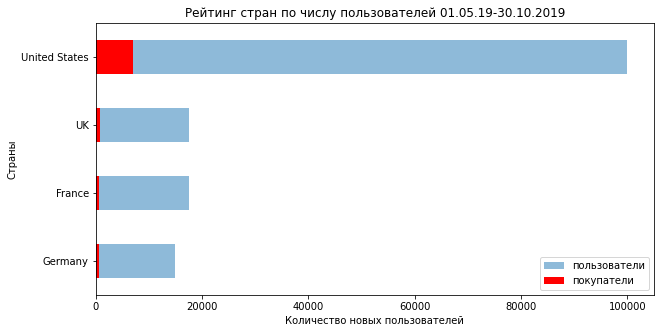

In [48]:
# Отобразим на графике число пользователей
ax = region_rating.sort_values(by='n_users')['n_users'].plot(
    kind='barh', figsize=(10,5), grid=True,
    legend=True, title="Рейтинг стран по числу пользователей 01.05.19-30.10.2019", alpha=0.5, label='пользователи')
region_rating.sort_values(by='n_users')['n_payers'].plot(
    kind='barh', figsize=(10,5), ax=ax, label='покупатели',
    legend=True, color='red')
plt.xlabel('Количество новых пользователей')
plt.ylabel('Страны')
plt.show()

Очевидно большая часть клиентов - из США и покупателей тоже.

**Посчитаем рейтинг устройств среди пользователей приложения**

In [49]:
# построим рейтинг устройств с помощью функции
device_rating = rate_by(['device'])
device_rating

,n_users,n_payers,users_share,payers_share,CR
device,,,,,
iPhone,54479,3382,0.363174,0.380813,0.062079
Android,35032,2050,0.233534,0.230830,0.058518
PC,30455,1537,0.203023,0.173066,0.050468
Mac,30042,1912,0.200269,0.215291,0.063644


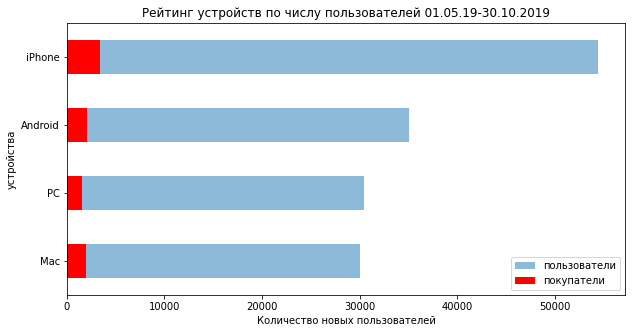

In [51]:
# Отобразим на графике число пользователей
ax = device_rating.sort_values(by='n_users')['n_users'].plot(kind='barh', figsize=(10,5), grid=True,
legend=True, title="Рейтинг устройств по числу пользователей 01.05.19-30.10.2019", alpha=0.5, label='пользователи')
device_rating.sort_values(by='n_users')['n_payers'].plot(kind='barh', figsize=(10,5), ax=ax, label='покупатели',
legend=True, color='red')
plt.xlabel('Количество новых пользователей')
plt.ylabel('устройства')
plt.show()

Больше всего клиентов пользуется айфонами - 36%, и примерно поровну остальными устройствами: на андроиде (23%), ПК (20%) и Мак (20%).  
Покупают также чаще владельцы айфонов - 38%, владельцы устройств на андроиде - 23%, чуть меньше владельцы ПК - 17% и владельцы Маков чуть больше - 21%.  
Т.е. конверсия владельцев Маков выше всех - 6,36%, затем идут айфоны - 6,2%, потом андроид - 5,8% и последними ПК - 5%.

**Построим рейтинг каналов привлечения пользователей**

In [52]:
# применяем функцию к каналам
channel_rating = rate_by(['channel'])
channel_rating

,n_users,n_payers,users_share,payers_share,CR
channel,,,,,
organic,56439,1160,0.376240,0.130616,0.020553
FaceBoom,29144,3557,0.194283,0.400518,0.122049
TipTop,19561,1878,0.130400,0.211463,0.096007
OppleCreativeMedia,8605,233,0.057364,0.026236,0.027077
LeapBob,8553,262,0.057017,0.029501,0.030633
WahooNetBanner,8553,453,0.057017,0.051008,0.052964
RocketSuperAds,4448,352,0.029652,0.039635,0.079137
MediaTornado,4364,156,0.029092,0.017566,0.035747
YRabbit,4312,165,0.028745,0.018579,0.038265


Итак, большая часть пользователей пришли сами: 37%, из платных источников на первом месте FaceBoom (19% пользователей), на втором TipTop (13%) и на третьем сразу три канала по 5,7% (OppleCreativeMediaб, LeapBob, WahooNetBanner), остальные привлекли менее 3%.  
Больше всего покупателей пришли через FaceBoom - 40%, на втором месте TipTop (21%) и на третьем месте органические посетители (13%).

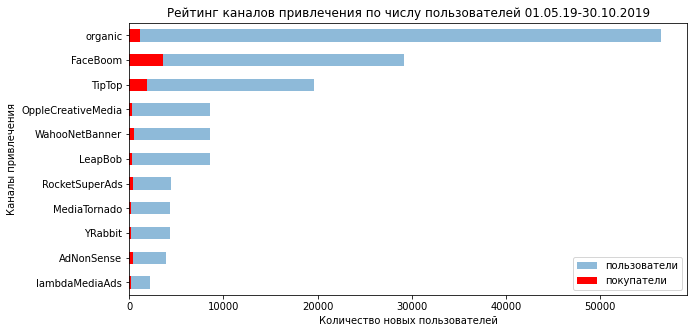

In [54]:
# Отобразим на графике число пользователей
ax = channel_rating.sort_values(by='n_users')['n_users'].plot(kind='barh', figsize=(10,5), grid=True,
legend=True, title="Рейтинг каналов привлечения по числу пользователей 01.05.19-30.10.2019", alpha=0.5, label='пользователи')
channel_rating.sort_values(by='n_users')['n_payers'].plot(kind='barh', figsize=(10,5), ax=ax, label='покупатели',
legend=True, color='red')
plt.xlabel('Количество новых пользователей')
plt.ylabel('Каналы привлечения')
plt.show()

Само по себе количество покупателей мало о чем говорит, учитывая разное количество пользователей. Можно сравнить конверсию разных каналов.

In [55]:
# сортируем рейтинг по коэффициенту конверсии
channel_rating.sort_values(by='CR', ascending=False)

,n_users,n_payers,users_share,payers_share,CR
channel,,,,,
FaceBoom,29144,3557,0.194283,0.400518,0.122049
AdNonSense,3880,440,0.025865,0.049544,0.113402
lambdaMediaAds,2149,225,0.014326,0.025335,0.104700
TipTop,19561,1878,0.130400,0.211463,0.096007
RocketSuperAds,4448,352,0.029652,0.039635,0.079137
WahooNetBanner,8553,453,0.057017,0.051008,0.052964
YRabbit,4312,165,0.028745,0.018579,0.038265
MediaTornado,4364,156,0.029092,0.017566,0.035747
LeapBob,8553,262,0.057017,0.029501,0.030633


Если отсортировать каналы по конвертации в покупателя, то на первом месте будет FaceBoom (12% пользователей что-то купили), за ним AdNonSense (11,3%), затем lambdaMediaAds (10%) и за ними TipTop (9,6%) (этом рейтинге этот источник на 4-м месте). Посетители пришедшие в приложение самостоятельно бесплатно начинают что-то покупать в приложении в 2% случаев - organic в этом рейтинге на последнем месте.

**Вывод**:  
За тот период данных, что мы рассматриваем (с мая по октябрь 2019-го) в приложении зарегистрировались 150008 новых пользователей, 8881 из них что-то купили в приложении.  
66% пользователей пришли из США и от 9 до 11% это жители Франции, Германии и Великобритании. Среди покупателей 77% пользователи из США, и примерно по 7% из каждой европейской страны. Т.е. конвертация в покупателя для США около 7%, а в остальных странах от 3,7 до 4%.  
Среди устройств лидирует айфон (35% пользователей и 38% покупателей), остальными устройствами на андроиде, ПК и Маком пользуются примерно одинаково - по 20%. Среди покупателей владельцев айфонов также больше чем других (38%), на втором месте владельцы устройств на андроиде - 23%, на третьем - владельцы Маков - 21% и на последнем - ПК - 17%. Т.е. конверсия владельцев Маков выше всех - 6,36%, затем идут айфоны - 6,2%, потом андроид - 5,8% и последними ПК - 5%.  
По каналам привлечения из платных источников на первом месте FaceBoom (19% пользователей), на втором TipTop (13%) и на третьем сразу три канала по 5,7% (OppleCreativeMediaб, LeapBob, WahooNetBanner), остальные пять привлекли менее 3% каждый. При этом большая часть пользователей пришли сами: 37%, но они реже всех что либо покупают в приложении (показатель конверсии 2%).  
Больше всего покупателей пришли через FaceBoom - 40%, на втором месте TipTop (21%) и на третьем месте органические посетители (13%).

## Маркетинг

Общие расходы на маркетинг за весь период с мая по октябрь в таблице с расходами.

In [56]:
int(df_costs['costs'].sum())

105497

За полгода в рекламу было вложено 105497 у.е. Посмотрим на динамику расходов.

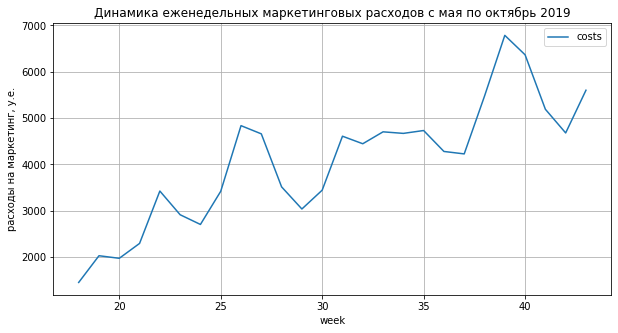

In [57]:
# группируем расходы на маркетинг по неделям и строим график
df_costs['week'] = pd.to_datetime(df_costs['dt']).dt.week
df_c = df_costs.copy()
df_c_pivoted = df_c.pivot_table(
    index='week',
    values= 'costs',
    aggfunc='sum'
)
df_c_pivoted.plot(figsize=(10,5), grid=True, title='Динамика еженедельных маркетинговых расходов с мая по октябрь 2019')

plt.ylabel('расходы на маркетинг, у.е.')
plt.show()

Похоже, что в течение полугода сильно выросли еженедельные вложения в маркетинг. Посмотрим более детально.

Посчитаем сколько денег было истрачено на привлечение пользователей через каждый платный канал.

In [58]:
d_c = df_costs.groupby('channel').agg(
    costs_sum = ('costs', 'sum')).sort_values(by='costs_sum', ascending=False)

d_c['share'] = d_c['costs_sum'] / d_c['costs_sum'].sum() 
d_c

,costs_sum,share
channel,,
TipTop,54751.30,0.518983
FaceBoom,32445.60,0.307549
WahooNetBanner,5151.00,0.048826
AdNonSense,3911.25,0.037074
OppleCreativeMedia,2151.25,0.020392
RocketSuperAds,1833.00,0.017375
LeapBob,1797.60,0.017039
lambdaMediaAds,1557.60,0.014764
MediaTornado,954.48,0.009047


Больше всего денег было вложено в TipTop - 54751 у.е. (52% всего бюджета), на втором месте FaceBoom - 32445 (30%). Это самые крупные вложения маркетинга за все шесть месяцев. Остальные 8 каналов стоили каждый меньше 5% в сумме меньше 20% всех расходов.

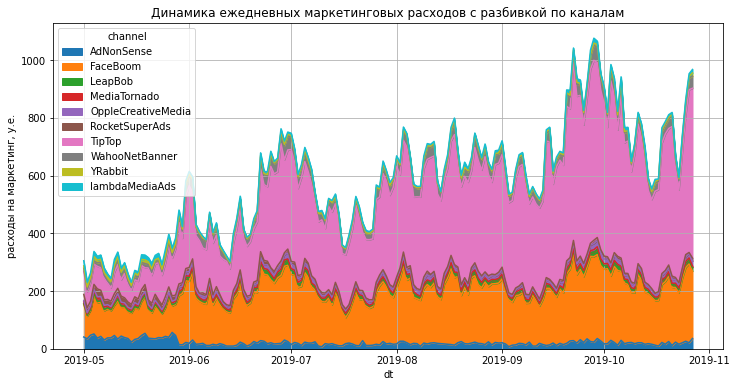

In [59]:
# строим график динамики расходов по каналам привлечения
df_costs.pivot_table(
    index='dt',
    columns='channel',
    values= 'costs',
    aggfunc='sum'
).plot.area(figsize=(12,6), grid=True, title='Динамика ежедневных маркетинговых расходов с разбивкой по каналам')
plt.ylabel('расходы на маркетинг, у.е.')
plt.show()

Начиная с июня маркетинговые расходы на каналы TipTop и FaceBoom выросли со 100 (в мае) до 300 у.е. в день, с июля расходы на TipTop продолжили рост, до 600 у.е. в октябре, а расходы на FaceBoom колебались в диапазоне от 100 до 300 у.е. При этом остальные каналы все время оставались в диапазоне до 20 у.е.

### Расчет CAC

Посчитаем сколько стоило привлечение одного пользователя в целом и по каждому каналу в отдельности. Сохраним число пользователей, которых привлекли через платные каналы, в отдельную переменную.

In [60]:
ad_users = len(profiles[profiles['channel'] != 'organic'])
ad_users

93569

In [61]:
cac_total = round(df_costs['costs'].sum() / ad_users, 2)
print('Привлечение одного пользователя за все шесть месяцев: {} у.е.'.format(cac_total))

Привлечение одного пользователя за все шесть месяцев: 1.13 у.е.


Итого, за полгода, потратив 105 тысяч у.е. мы привлекли 93,5 тысячи пользователей. Каждый в среднем обошелся нам в 1,13 у.е.

Посчитаем стоимость привлечения пользователя по каждому каналу.

In [62]:
# считаем средний CAC по каналам привлечения
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)

cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Дороже всего стоит пользователь пришедший из TipTop - 2,79 у.е., затем идут пользователи каналов FaceBoom - 1,11 и AdNonSense - 1 у.е. 

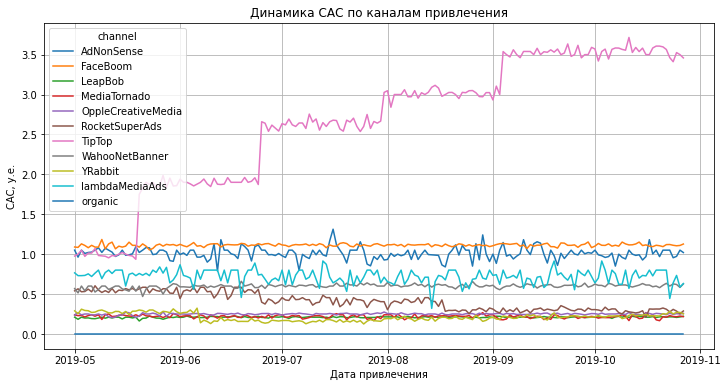

In [63]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(12, 6))
plt.ylabel('CAC, у.е.')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

За полгода расходы на маркетинг в целом были постоянными на всех источниках кроме TipTop. По нему расходы выростали пять раз за это время с 1 до 3,5 у.е. И было снижение на расходы на RocketSuperAds с 0,6 до примерно 0,25 у.е.

**Вывод**:  
В среднем привлечение одного пользователя через платные каналы стоит 1,13 у.е. 
Заметно дороже стоит пользователь из канала TipTop - 2,79 у.е. в среднем, при этом TipTop пять раз за полгода поднимал цену и последние два месяца CAC этого канала 3,5 у.е. Нужно будет обратить внимание на рентабельность этого канала.   
Остальные каналы за полгода не росли в цене и только RocketSuperAds подешевел с примерно 0,6 до 0,3.  
На втором месте по цене пользователь с FaceBoom (который привлек нам 20% пользователей и 40% покупателей), он обходится в 1,11 у.е. Нужно будет посмотреть окупается ли такая цена.  
Остальные стоят дешевле от 0,2 до 0,7 у.е. 

## Окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Общая окупаемость рекламы

Посмотрим какой доход мы получили за полгода, сколько принесли нам платные пользователи и сколько органические.

In [64]:
# добавим в таблицу с заказами канал из таблицы пользователей
df_orders_ch = df_orders.merge(profiles[['user_id', 'channel']], on='user_id', how='left')
# сохраним маркер для платных пользователей в отдельный столбец
df_orders_ch['ad_user'] = df_orders_ch['channel'] != 'organic'
# посчитаем сумму дохода для платных и бесплатных пользователей
df_orders_pivoted = df_orders_ch.pivot_table(
    
    values='revenue',
    aggfunc='sum',
    index='ad_user',
    margins=True
)
# добавим столбец где считаем долю от общей суммы выручки
df_orders_pivoted['share'] = df_orders_pivoted['revenue'] / df_orders['revenue'].sum()
df_orders_pivoted

,revenue,share
ad_user,,
False,46627.23,0.215904
True,169335.65,0.784096
All,215962.88,1.000000


За полгода мы получили доход 215962 у.е. из которых 46627 (21,5%) принесли бесплатые органические пользователи, а 169335 (78,5%) те, что пришли через платные каналы привлечения. Общая сумма расходов на рекламу - 105497 у.е. - меньше чем доход от платных пользователей. Можно сказать, что в целом за шесть месяцев доходы больше расходов.

In [65]:
# общие расходы на рекламу
df_costs['costs'].sum()

105497.30000000002

In [66]:
# окупаемость рекламы в целом за полгода
round(df_orders_pivoted.loc[1][0] / df_costs['costs'].sum(),2)

1.61

Получается, что доходы за полгода выше рекламных расходов в 1,6 раза. Можно сказать, что за полгода привлечение пользователей окупается. Но окупается ли пользователь за две недели с момента привлечения? Чтобы детализировать анализ, мы применим оценим экономику одного покупателя: посчитаем доходы и расходы на одного покупателя в целом, в разбивке по каналам привлечения, устройствам и странам, вычислим рентабельность и посмотрим на динамику метрик.

Чтобы оценить окупаемость рекламы нужно сравнить доход от покупателя с расходами на его привлечение. Для это посчитаем показатель пожизненной ценности - LTV, т.е. доход с пользователя. Для начала можно оценить доход с одного пользователя как общий доход деленный на количество пользователей за период.

In [67]:
print('Доход с одного пользователя вместе с органическими за полгода {:.2f} у.е.'.format(
    df_orders['revenue'].sum() / len(profiles)))

Доход с одного пользователя вместе с органическими за полгода 1.44 у.е.


In [68]:
print('Доход с одного органического пользователя за полгода {:.2f} у.е.'.format(
    df_orders_pivoted.loc[0][0] / len(profiles[profiles['channel'] == 'organic'])))

Доход с одного органического пользователя за полгода 0.83 у.е.


In [69]:
print('Доход с одного платного пользователя за полгода {:.2f} у.е.'.format(
    df_orders_pivoted.loc[1][0]/ len(profiles[profiles['channel'] != 'organic'])))

Доход с одного платного пользователя за полгода 1.81 у.е.


Мы уже знаем, что средний САС за весь период (в переменной `cac_total`) = 1,13 у.е. Т.е. в целом за полгода доход на платного клиента выше расходов. На 0,58 у.е. - меньше чем приносит нам органический пользователь.

Но пользователи должны окупаться в течение двух недель после привлечения. Посмотрим на метрику за последние две недели от даты анализа (считаем что это 1 ноября 2019). Посчитаем LTV, построим тепловую карту и график динамики метрики.

Для оценки общей окупаемости выбираем следующие параметры для применения функции `get_ltv`.    \
Момент анализа данных - 01.11.2019,  
горизонт анализа данных - 14 дней (т.к. в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения),  
параметр dimensions оставляем пустым.

In [70]:
moment = datetime(2019, 11, 1).date()
horizon = 14

Корректно будет сравнивать доход от пользователя и расход на его привлечение только по тем, кто был привлечен через платные каналы. Для этого выделим таких пользователей отдельно.

In [71]:
# сохраняем в отдельную переменую пользователей из платных каналов
ad_profiles = profiles[profiles['channel'] != 'organic']
ad_profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93569 entries, 0 to 150006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           93569 non-null  int64         
 1   first_ts          93569 non-null  datetime64[ns]
 2   channel           93569 non-null  object        
 3   device            93569 non-null  object        
 4   region            93569 non-null  object        
 5   dt                93569 non-null  object        
 6   month             93569 non-null  datetime64[ns]
 7   payer             93569 non-null  bool          
 8   acquisition_cost  93569 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 6.5+ MB


In [72]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(ad_profiles, df_orders, moment, horizon)

In [73]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


**Тепловая карта LTV**

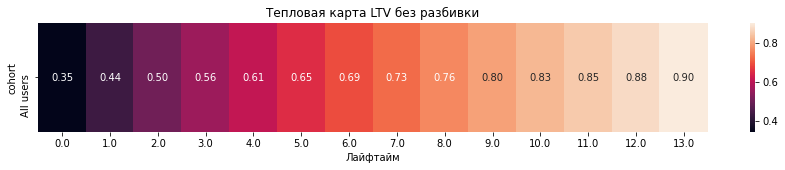

In [74]:
plt.figure(figsize=(15,2))
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV без разбивки')
plt.xlabel('Лайфтайм')
plt.show()

За последние две недели LTV на конец периода был 0,9 у.е. Это ниже показателя цены одного пользователя (CAC) - 1,13 который мы получили раньше. А значит можно предположить, что за две недели эти пользователи не окупаются, тем более что мы знаем, что расходы в последние месяцы были выше среднего.

Посмотрим на показатель окупаемости клиента, его мы получили раньше, когда применяли функцию `get_ltv`.

In [75]:
roi

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,,
All users,88644,1.117794,0.309163,0.389834,0.451341,0.501962,0.547002,0.58541,0.620991,0.652873,0.684043,0.712711,0.739091,0.762278,0.785579,0.806974


Очевидно, что рентабельность росла, но к концу двух недель так и не достигла уровня окупаемости, на последний день показатель ROI (0,8) всё ещё меньше 1.

**Построим графики динамики LTV ROI и САС.**

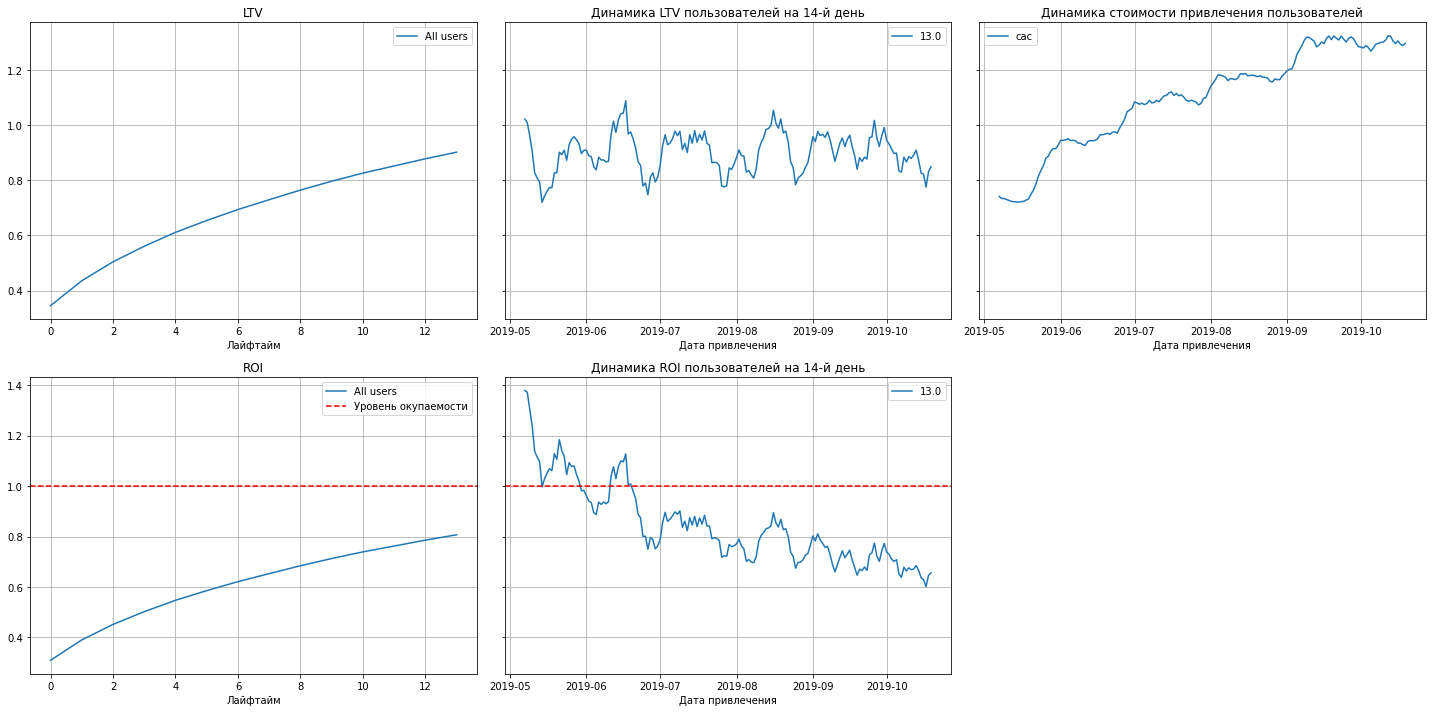

In [76]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7)

Кривая LTV выглядит ожидаемо, растет от 0 до 0,9, но показатель средних расходов не превышает. Очевидно, что привлечение пользователей как минимум за последние 14 дней не окупается.  
Похоже, что усредненный за 7 дней доход с пользователя никогда не достигал 1,13 у.е. за все полгода. Метрика подвижна в течение месяца (она скачет от 0,8 до 1) и похоже что в сентябре доходы стали чуть более стабильными, разница между экстремумами стала чуть меньше, и в октябре началось снижение доходов.  
Если мы посмотрим на график динамики LTV при значении переменной `windows` = 1 дню, т.е. без сглаживания, то видим, что несколько когорт все таки смогли принести больше 1.13 на 14-й день. Но в целом средняя доходность лежит где-то в районе 0,9.  
Видим, что стоимость привлечения заметно выросла за полгода - примерно в два раза, и одовременно снизилась рентабельность пользователя - за весь период также примерно в два раза, уже в июне она начала показывать убытки и к концу октября ROI 14-го дня чуть выше 0,6.

### Окупаемость рекламы с разбивкой по странам

Для оценки LTV с разбивкой по странам выбираем следующие параметры для применения функции `get_ltv`.    \
Момент анализа данных - 01.11.2019,  
горизонт анализа данных - 14 дней,  
dimensions=['region'].

In [77]:
moment = datetime(2019, 11, 1).date()
horizon = 14

In [78]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(ad_profiles, df_orders, moment, horizon, dimensions=['region'])

In [79]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.193428,0.259783,0.311696,0.360199,0.406892,0.450173,0.481019,0.507213,0.541484,0.570906,0.600042,0.621870,0.649871,0.670278
Germany,9030,0.186350,0.258858,0.327945,0.375473,0.422776,0.460907,0.496938,0.534074,0.571104,0.605367,0.641507,0.665932,0.691355,0.713019
UK,10536,0.218683,0.296762,0.367626,0.416607,0.465505,0.503964,0.556090,0.585644,0.623741,0.645527,0.668830,0.692322,0.719800,0.743481
United States,58562,0.420285,0.519636,0.590981,0.651779,0.703511,0.747926,0.787655,0.825852,0.859873,0.893893,0.923530,0.950849,0.976382,1.001316


Судя по цифрам больше денег приносят пользователи из США. Построим тепловую карту для наглядности.

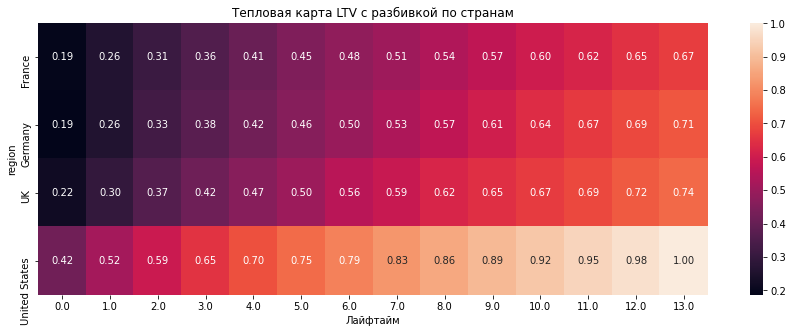

In [80]:
# строим тепловую карту LTV с разбивкой по странам
plt.figure(figsize=(15, 5))
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV с разбивкой по странам')
plt.xlabel('Лайфтайм')
plt.show()

Видно, что доход с пользователя из США на 14 день после регистрации 1 у.е., Великобритании 0.74, Германии 0,71 и из Франции 0,67.

Посмотрим на показатель окупаемости клиента, его мы получили раньше, когда применяли функцию `get_ltv`.

In [81]:
roi

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,,
France,10516,0.459836,0.420645,0.564947,0.677842,0.783319,0.884863,0.978985,1.046066,1.103029,1.177559,1.241542,1.304903,1.352373,1.413265,1.457644
Germany,9030,0.464898,0.400840,0.556806,0.705411,0.807645,0.909395,0.991414,1.068917,1.148797,1.228449,1.302148,1.379887,1.432426,1.487111,1.533709
UK,10536,0.454922,0.480704,0.652335,0.808109,0.915777,1.023264,1.107802,1.222385,1.287350,1.371094,1.418984,1.470208,1.521847,1.582249,1.634306
United States,58562,1.455876,0.288682,0.356923,0.405928,0.447689,0.483222,0.513729,0.541018,0.567254,0.590622,0.613990,0.634347,0.653111,0.670649,0.687776


Любопытно, что рентабельность у клиентов из европейских стран выше, чем у американских. Посмотрим наглядно.

Построим графики динамики LTV ROI и САС.

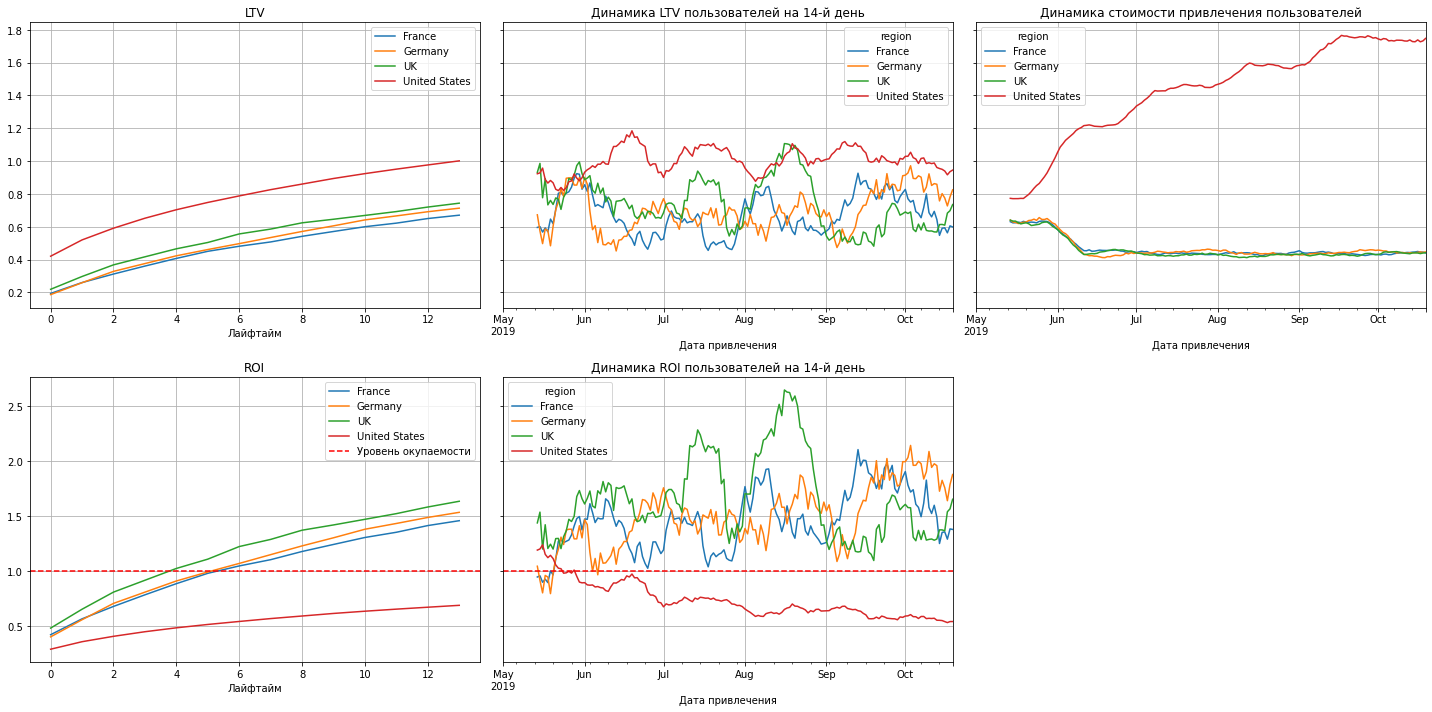

In [82]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

На кривой LTV очевиден отрыв в доходности американских клиентов.  
Динамика за весь период с мая показывает, что пользователи привлеченные в разное время даже внутри одних стран дают совершенно разные доходности. В некоторые периоды пользователи из Германии, Великобритании и иногда Франции покупали больше американцев. Очевидно, что средняя кривой США выше чем других стран, но шумность показателей говорит о том, что страна клиента не определяющий фактор в доходности. Возможно, что-то еще оказывает влияние, может быть сезонность. В среднем метрика колеблется от 0,5 до 1,2 у.е.  
Графики рентабельности показывают, что клиенты из США не окупаются как в последние две недели, так и за весь период, а вот европейские клиенты начинают окупать расходы уже на 4-й день после регистрации.  
Очевидно потому, что стоимость привлечения клиента из США выросла за полгода в два с лишним раза с 0,8 до 1,7 у.е., а в остальных странах снизилась с 0,6 до 0,4 примерно.  
Наилучшую рентабельность показывают клиенты из Великобритании, если смотреть на график ROI за последние две недели.  
Судя по графику динамики окупаемости на 14 день за весь период клиенты из Великобритании показывали хорошую отдачу в июле и августе, а в последние два месяца лидирует Германия и Франция. Рентабельность американских клиентов упала ниже уровня окупаемости еще в июне и с тех пор только снижается.

### Окупаемость рекламы с разбивкой по рекламным каналам

Для оценки LTV с разбивкой по каналам выбираем следующие параметры для применения функции `get_ltv`.    \
Момент анализа данных - 01.11.2019,  
горизонт анализа данных - 14 дней,  
dimensions=['channel'].

In [83]:
moment = datetime(2019, 11, 1).date()
horizon = 14

In [84]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(ad_profiles, df_orders, moment, horizon, dimensions=['channel'])

In [85]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.505030,0.589149,0.644417,0.683509,0.706694,0.732582,0.754149,0.767628,0.789203,0.802682,0.806996,0.815084,0.827215,0.838006
FaceBoom,27544,0.585703,0.660825,0.700722,0.728842,0.747143,0.760369,0.774718,0.784757,0.792404,0.800775,0.806247,0.812226,0.817483,0.821469
LeapBob,8103,0.107048,0.155702,0.205583,0.235391,0.259654,0.288599,0.314587,0.333802,0.369543,0.394176,0.417579,0.437902,0.457608,0.473004
MediaTornado,4167,0.137485,0.191615,0.246943,0.293667,0.332249,0.366979,0.388534,0.418474,0.440034,0.461589,0.485541,0.508294,0.526256,0.533684
OppleCreativeMedia,8139,0.097239,0.131578,0.171686,0.206636,0.241103,0.266240,0.290152,0.309527,0.328544,0.346938,0.364228,0.376613,0.395017,0.409118
RocketSuperAds,4251,0.207570,0.318640,0.396114,0.455980,0.515613,0.571019,0.639125,0.687255,0.737986,0.790118,0.831437,0.864307,0.898586,0.933801
TipTop,18498,0.343550,0.497389,0.624141,0.739834,0.842358,0.935707,1.013676,1.096450,1.171400,1.245485,1.311417,1.371467,1.427640,1.487908
WahooNetBanner,8082,0.191302,0.291477,0.378921,0.443754,0.516862,0.569469,0.631870,0.678176,0.725353,0.765488,0.812535,0.849334,0.889472,0.918615
YRabbit,4102,0.163301,0.213423,0.256000,0.303932,0.356265,0.387894,0.414656,0.438988,0.460885,0.480349,0.502245,0.524147,0.546287,0.559668


Построим тепловую карту для наглядности.

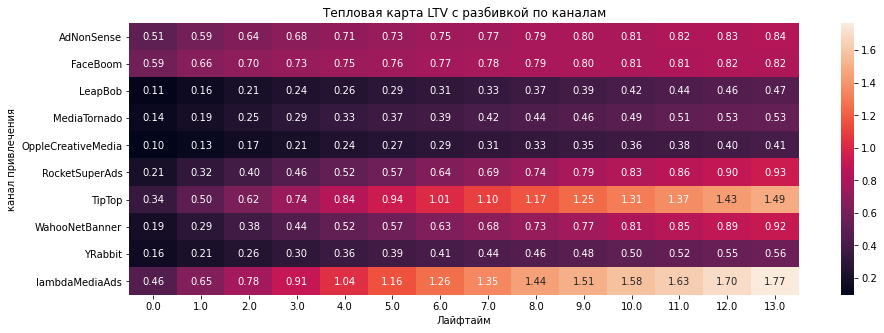

In [86]:
# строим тепловую карту LTV с разбивкой по каналам
plt.figure(figsize=(15, 5))
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV с разбивкой по каналам')
plt.xlabel('Лайфтайм')
plt.ylabel('канал привлечения')
plt.show()

Наибольший доход приносят на 14-й день пользователи пришедшие через каналы: TipTop - 1,49 и lambdaMediaAds - 1,77 у.е. Последний источник привлек меньше всего пользователей, которые приносят больше всего денег - на него стоит обратить внимание. Доход с остальных меньше 1, т.е. меньше среднего САС. Чтобы оценить насколько они рентабельны нужно сравнивать с расходами по конкретному источнику.

Используем функцию plot_ltv_roi для построения графиков.

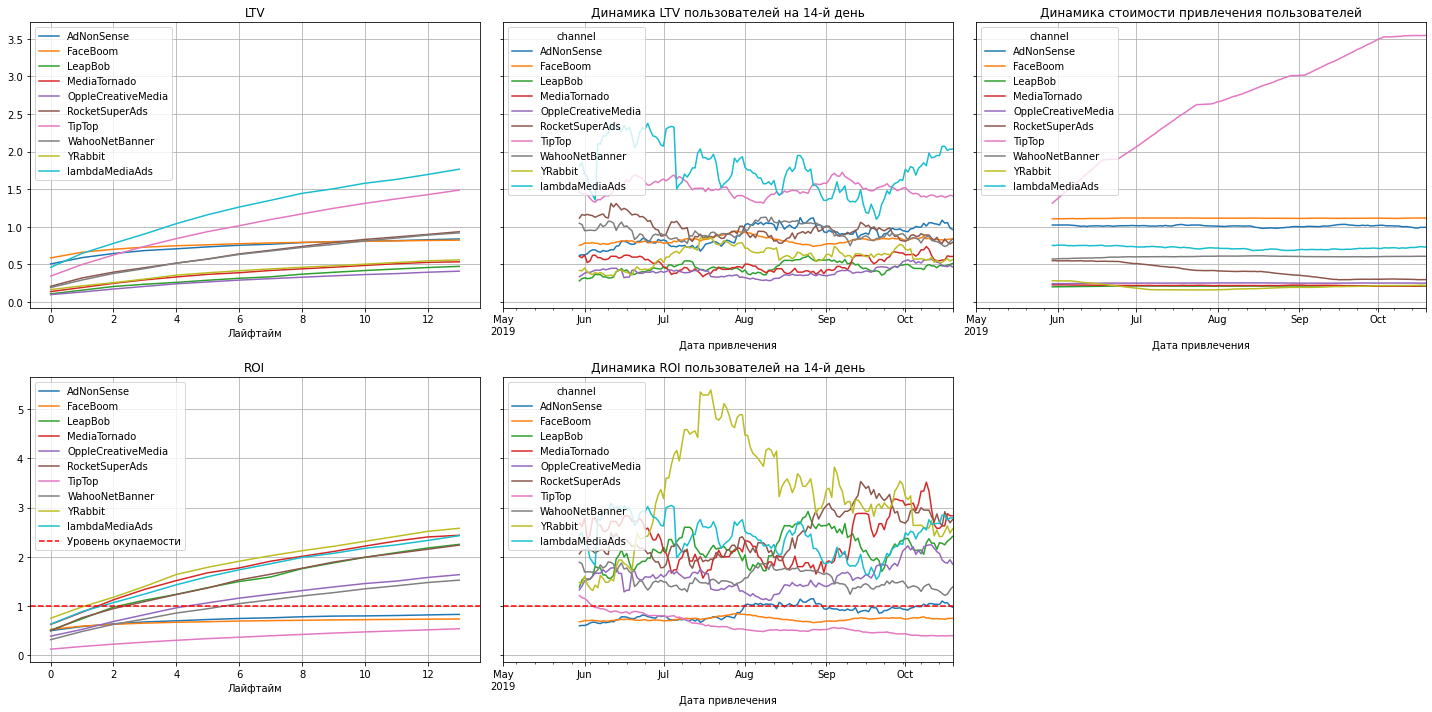

In [87]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=30)

На кривой LTV видим, что очень хорошо растет в течение 14 дней доход от lambdaMediaAds, а также TipTop. Остальные каналы показывают заметно меньшие темпы роста в течение жизни когорты. Можно отметить, что на следующем месте по темпам роста доход с каналов RocketSuperAds и WahooNetBanner. Можно тоже к ним присмотреться.
При сглаживании менее 14 дней график динамики LTV получается очень шумным, можно считать, что на окупаемость влияют и другие факторы кроме источника привлечения. Однако по нему очевидны два лидера - это канал lambdaMediaAds (было снижение, но и хороший рост в последний месяц) и TipTop - они показывали лучшие доходы все полгода, с некоторыми падениями, но все таки всегда выше 1 у.е.  
В районе 1 у.е. показывали доходы каналов RocketSuperAds (снижение в течение полугода), WahooNetBanner (немного снижается сейчас), и рост показал доход канала AdNonSense с 0,6 до 1 - его точно стоит рассмотреть как перспективный.
Судя по графику рентабельности за последние две недели три канала не окупаются в течение 14 дней. Это TipTop, FaceBoom и AdNonSense.  
Если смотреть динамику за полгода, то последний канал начал окупаться примерно в августе и с тех пор его рентабельность остается в районе 1, а вот канал TipTop перестал окупаться в июне и приносит все больше убытков, что не удивительно, учитывая, что затраты на него выросли в три раза.  
Остальные каналы похоже окупают себя. Можно отметить, что YRabbit показывал очень хорошую окупаемость летом - больше 5, и хотя его ROI снижается уже три месяца, он все еще входит в группу самых прибыльных.

**Вывод:**  
Мы выяснили, что рентабельность клиента стала отрицательной с июня 2019, произошло это за счет роста расходов на рекламу. 
Стоимость привлечения клиентов из США росла постоянно и за полгода увеличилась с 0,8 до 1,7 у.е., при этом стоимость европейского клиента снизилась до 0,4. В итоге, хотя американские пользователи покупают на большие суммы чем европейские (двухнедельный LTV американца 1 у.е. против 0,7 европейца), привлечение американских клиентов приносит убытки уже с июня и с каждым месяцем все больше. Показатель ROI на конец периода по США около 0,6.  
При разбивке по каналам привлечения убытки приносят каналы: TipTop и FaceBoom. И хотя TipTop это один из самых крупных каналов привлечения для нас и его клиенты покупают больше прочих, расходы на него выросли за полгода в три раза (с 1,3 до 3,5), он перестал окупаться в июне и рентабельность продолжает снижаться (на конец октября это около 0,5). Канал FaceBoom весь период показывал рентабельность ниже 0,8.  
Еще один канал аутсайдер - AdNonSense - был нерентабельным до августа и последние три месяца вышел на окупаемость, но его ROI едва превышает 1 к концу октября.  
Остальные каналы себя окупают. Можно отметить хорошую динамику рентабельности канала lambdaMediaAds за последний месяца, показатель ROI вырос с 1,6 до 2,8.

### Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Чтобы построить график удержания воспользуемся функцией `plot_retention`. Зададим момент анализа, горизонт анализа и окно сглаживания. Чтобы рассчитать удержание по странам, каналам и устройствам нужно рассчитать его с соответствующим параметром dimensions. Построим их на основе полной таблицы профилей.

In [88]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
window = 7

#### Графики RR и CR по странам

In [89]:
# считаем удержание по странам
retention_raw, retention, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions = ['region'], ignore_horizon = False)

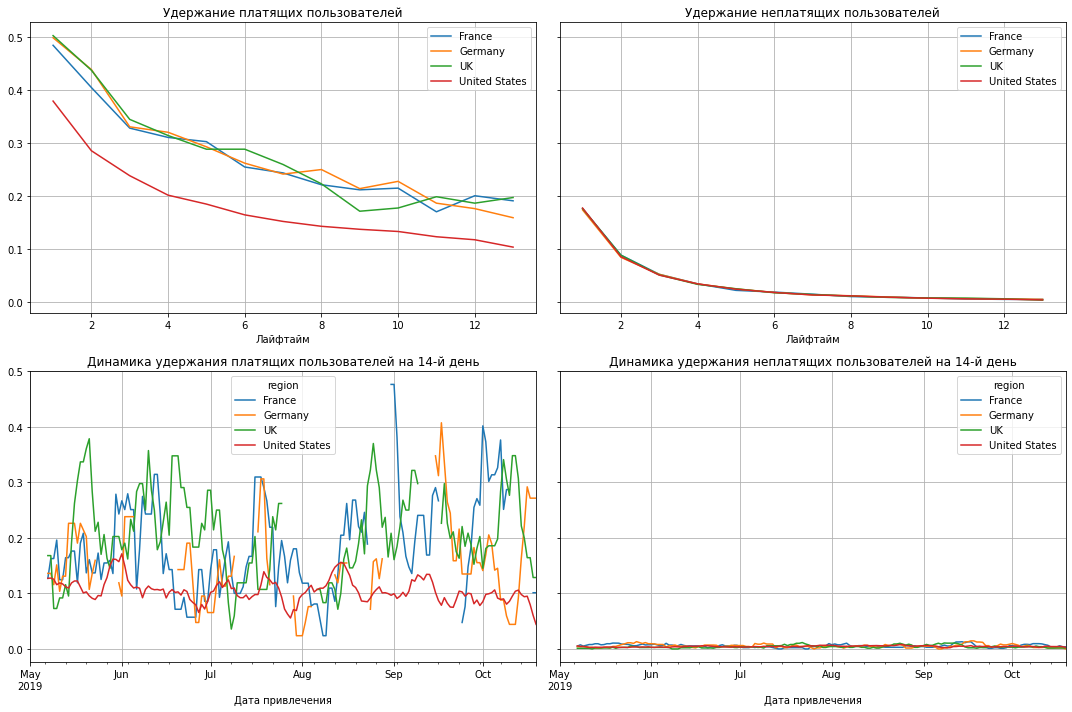

In [90]:
# строим графики удержания с помощью функции
plot_retention(retention, retention_history, horizon_days, window)

Показатели удержания платящих клиентов из европейских стран лучше чем американских, на графике удержания за последние две недели 0,2 против 0,1 к 14 дню "жизни". Удержание неплатящих пользователей одинаково низко по всем странам и падает до 0 к 14-му дню.  
Динамика удержания за шесть месяцев рассчитанная на 14 день после регистрации также в среднем выше по европейским клиентам (хотя этот показатель очень сильно колеблется, от 0,05 до 0,4), у американских клиентов удержание более стабильно в районе 0,1, с некоторыми всплесками от 0,08 до 0,18 в отдельные месяцы. Нельзя сказать, что наблюдается рост или снижение, скорее график шумит из-за действия других факторов. И удержание неплатящих пользователей на 14-й день в течение всех 6 месяцев было постоянно на уровне ноля. 

Построим графики конверсии с разбивкой пользователей по странам.

In [91]:
# вычисляем конверсию и динамику конверсии с помощью функции
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    df_orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

In [92]:
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,16624,0.024362,0.028152,0.030618,0.032122,0.033446,0.034288,0.034889,0.035190,0.035671,0.036153,0.036273,0.036634,0.036754,0.036814
Germany,14244,0.025274,0.030890,0.033418,0.035383,0.036226,0.037209,0.037770,0.038472,0.039034,0.039385,0.039455,0.039525,0.039596,0.040017
UK,16710,0.025913,0.029922,0.032615,0.033872,0.035009,0.035667,0.036505,0.037044,0.037283,0.037642,0.037882,0.037941,0.038061,0.038121
United States,95042,0.048799,0.055270,0.058206,0.060436,0.062057,0.063035,0.063867,0.064687,0.065308,0.065876,0.066223,0.066497,0.066697,0.066949


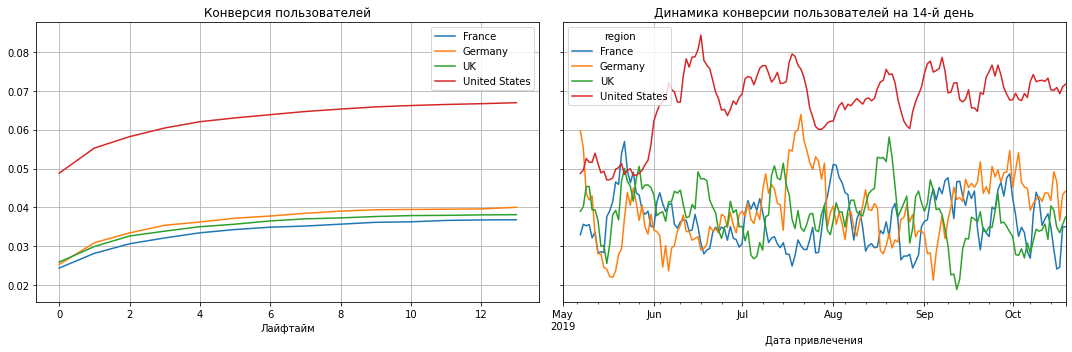

In [93]:
# строим кривую конверсии и динамику конверсии
plot_conversion(conversion, conversion_history, horizon_days, window)

Мы получили конверсию пользователей за последние две недели. Как видим пользователи из США заметно чаще что-то покупают в приложении, на 14 день показатель конверсиии около 0,067 для американцев (т.е. 6,7% из них что-то купили) и 0,04 для жителей Германии и чуть меньше для британцев и французов.  
График динамики конверсии за полгода показывает, что это положение типично для всех месяцев начиная с июня, только полгода назад в мае конверсия всех пользователей была близка - на уровне 0,05, а затем клиенты из США стали в 1,5 раза чаще конвертироваться в покупателей. Внутри месяцев метрика очень подвижна, для США в диапазоне от 6 до 8%, для Европы - от 3 до 5%.

#### Графики RR и CR по каналам

In [94]:
# считаем удержание по каналам
retention_raw, retention, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions = ['channel'], ignore_horizon = False)

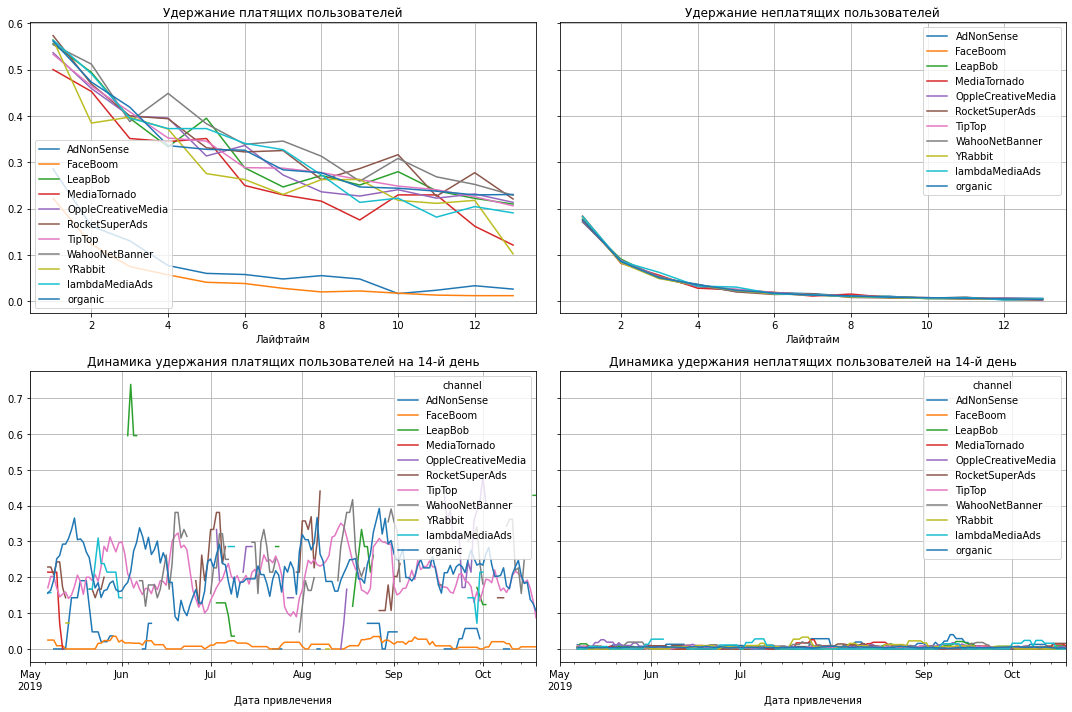

In [95]:
# строим графики удержания с помощью функции
plot_retention(retention, retention_history, horizon_days, window=7)

На двухнедельном графике удержания платящих пользователей заметно отличаются два аутсайдера: FaceBoom и organic - их показатель удержания падает с 0,3 до почти нуля за две недели. Можно сказать, что клиенты из FaceBoom отпадают также как и те, кто пришли к нам бесплатно. Остальные каналы показывают близкие значения, на 14 день жизни когорты удержание по ним снижается в среднем до 0,2 и по двум каналам до 0,1 (YRabbit и MediaTornado).  
Полугодовая динамика удержания показывает, что FaceBoom стабильно теряет пользователей на 14-й день. Остальные каналы показывают очень переменные значения удержания в диапазоне от 0,1 до 0,4.  
Неплатящие пользователи одинаково перестают пользоваться сервисом уже на 14 день после регистрации, как платные так и бесплатные.

**Построим графики конверсии с разбивкой пользователей по каналам.**

In [96]:
# вычисляем конверсию и динамику конверсии с помощью функции
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    df_orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

In [97]:
# рейтинг каналов по величине конверсии на последний день жизни когорты
conversion[13].sort_values(ascending=False)

channel
FaceBoom              0.119373
AdNonSense            0.107509
lambdaMediaAds        0.103599
TipTop                0.093740
RocketSuperAds        0.073630
WahooNetBanner        0.052091
YRabbit               0.037055
MediaTornado          0.033357
LeapBob               0.029248
OppleCreativeMedia    0.026293
organic               0.019879
Name: 13.0, dtype: float64

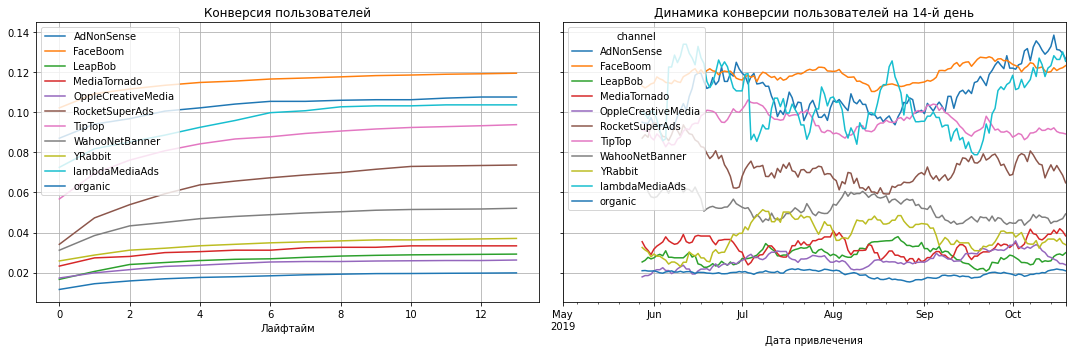

In [98]:
# строим кривую конверсии и динамику конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=28)

Конверсия по каналам заметно отличается, можно выделить каналы лидеры по конверсии и каналы аутсайдеры. Топ-3 каналов: 
- FaceBoom - 0.12
- AdNonSense - 0.10
- lambdaMediaAds - 0.10  

пять худших по конверсии каналов:  
- YRabbit - 0.037
- MediaTornado - 0.033
- LeapBob - 0.029
- OppleCreativeMedia - 0.026
- organic - 0.019.

#### Графики RR и CR по устройствам

In [99]:
# считаем удержание по устройствам
retention_raw, retention, retention_history = get_retention(
    profiles, df_visits, observation_date, horizon_days, dimensions = ['device'], ignore_horizon = False)

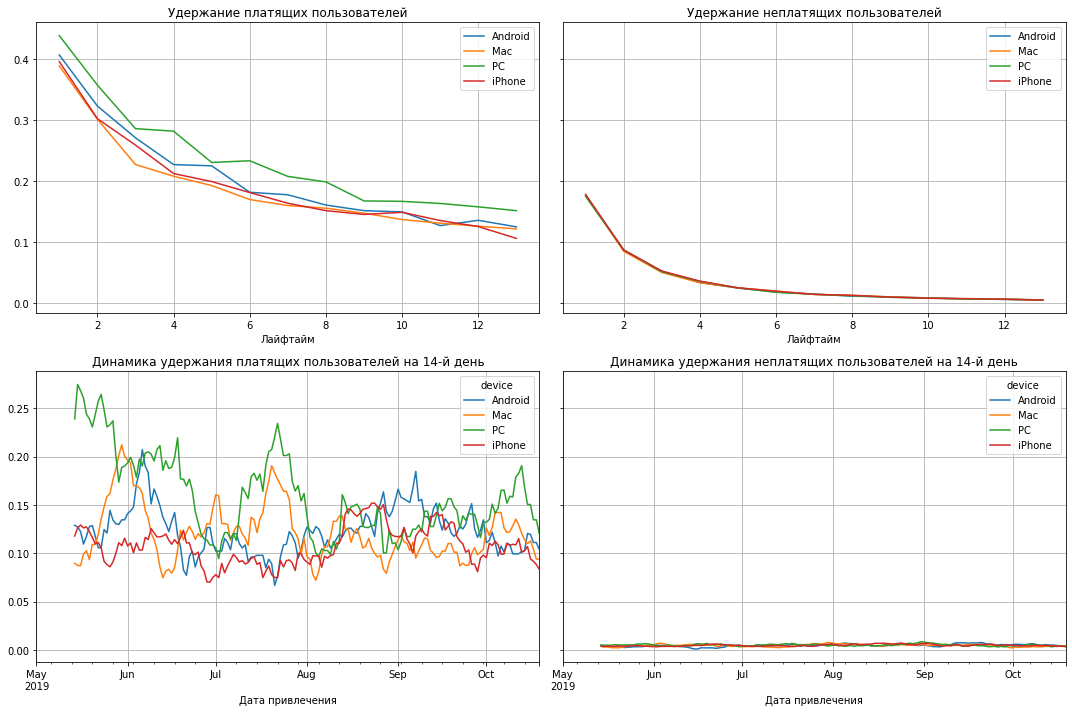

In [100]:
# строим графики удержания с помощью функции
plot_retention(retention, retention_history, horizon_days, window=14)

В последней когорте показатель удержания платящих пользователей примерно одинаков для всех устройств, он снижается к 14 дню до 0,12, с небольшим отрывом для пользователей ПК, их удержание около 0,15 к концу периода.  
Динамика метрики за полгода показывает, что в среднем для всех устройств она колеблется от 10 до 15%. При этом в начале периода удержание владельцев ПК доходило до 25%, но с августа сравнялось с другими устройствами.  
Удержание неплатящих пользователей ожидаемо находится в районе нуля на 14 день жизни когорты.

**Построим графики конверсии с разбивкой пользователей по устройствам.**

In [101]:
# вычисляем конверсию и динамику конверсии с помощью функции
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    df_orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

In [102]:
# рейтинг по величине конверсии на последний день жизни когорты
conversion[13].sort_values(ascending=False)

device
Mac        0.061634
iPhone     0.060020
Android    0.057258
PC         0.048554
Name: 13.0, dtype: float64

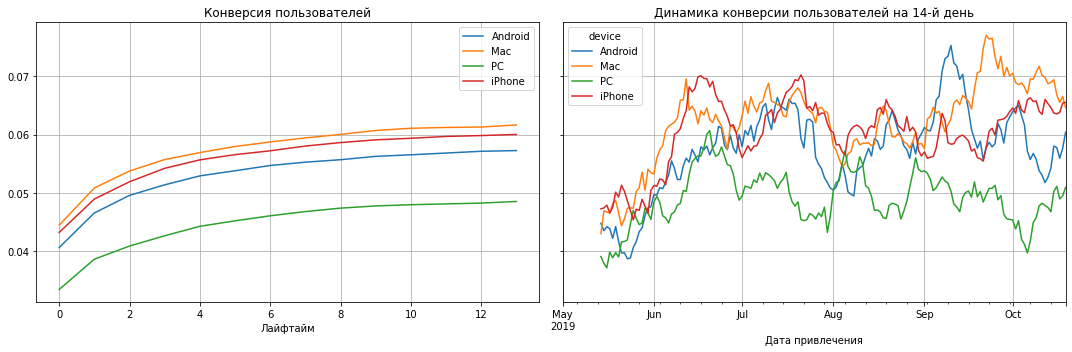

In [103]:
# строим кривую конверсии и динамику конверсии
plot_conversion(conversion, conversion_history, horizon_days, window=14)

График конверсии последней когорты показывает, что лучше всего в покупателя конвертируются владельцы Маков - в 6% на 14й день, хуже всего пользователи ПК - 4,8%.  
Динамика конверсии за полгода в целом говорит о том, что в июне конверсия нарастала по всем устройствам от 4% до 6-7%, но затем начались колебания и клиенты на ПК вернулись к 5% конверсии. По андроидам был период в конце сентября, где они конвертировались с показателей больше 7% и выходили на первое место, но потом уступили айфонам и макам.

## Выводы и рекомендации  

*Исходные данные о посещениях, заказах и расходах на рекламу, за полгода с мая по октябрь 2019, были чистые, без пропусков и ошибок, поэтому мы их использовали как есть, без исправлений.*  

**Основные выводы:**  

- Реклама в целом не окупается
- Основные убытки приносят два рекламных канала (TipTop и FaceBoom) и один регион (США)

***Рекомендации:*** 

- Чтобы сократить убытки стоит: 
    * повысить удержание платящих пользователей из США и клиентов пришедших с канала FaceBoom
    * повысить конвертацию в покупателя европейских клиентов и посетителей перспективных недорогих каналов 
    * увеличить привлечение пользователей из других регионов кроме США
    * перенаправить рекламный бюджет на более дешевые каналы с хорошими показателями рентабельности
***
**Аргументация**

- **Реклама в целом не окупается**

За полгода в рекламу было вложено 105 тысяч, в приложение по рекламным каналам пришли 93 тыс. новых пользователей, которые принесли к концу октября 169 тысяч дохода. Клиент не окупает своё привлечение к концу второй недели уже пять месяцев. В среднем привлечение стоит 1,13, а доход на 14 день - 0,8-1 у.е. в среднем.  

**Первая проблема** это высокая стоимость канала TipTop: цена клиента выросла за период с 1 до 3,5 у.е., а доход с клиента остался прежним - около 1,5. Это второй по объему источник привлечения клиентов в приложение (13% новых пользователей и 21% покупателей) не считая органических (37% пользователей приходят сами). Но первый по объему рекламных расходов - 52% от общей суммы или почти 55 тысяч было вложено в рекламу на TipTop.  
**Решение: выбрать более дешевый канал**  
Есть рекламные каналы с положительной рентабельностью и среди них лучшие показатели конверсии у lambdaMediaAds: 

| Канал              |  ROI   |   CR   |  CAC  |
|:------------------ |--------| -------|-------|
| YRabbit            |  2.58  |  0.037 |  0.22 |
| MediaTornado       |  2.44  |  0.033 |  0.22 |
| lambdaMediaAds     |  2.43  |  0.103 |  0.72 |
| LeapBob            |  2.25  |  0.029 |  0.21 |
| RocketSuperAds     |  2.24  |  0.073 |  0.41 |
| OppleCreativeMedia |  1.64  |  0.026 |  0.25 |
| WahooNetBanner     |  1.53  |  0.052 |  0.60 |


**Вторая проблема** это отток покупателей канала FaceBoom. Его метрика удержания платящих пользователей на 14 день находится на уровне органических пользователей - их RR падает с 0,3 до почти нуля за две недели. На рекламу в FaceBoom мы потратили 30% бюджета или 32 тысячи, через него мы привлекли 19% новых клиентов и 40% покупателей, но эти покупатели приносять только 0,8 дохода к концу второй недели, а стоят 1,1. И этот канал никогда не окупается. Хотя у него самая высокая конверсия - 12% посетителей становятся покупателями, они покидают приложение в течение двух недель.  
**Решение: найти причину оттока и повысить удержание этого канала**  

**Третья проблема:** высокая цена американского клиента и его низкое удержание. 100 тысяч новых пользователей (или 66% от всех привлеченных) были из США. Их отличает хорошая конвертируемость в покупателя (CR 7.9%) в отличие от европейского (около 4%) и хороший показатель дохода с клиента - 1 у.е. к 14-му дню, (в то время как европейский покупатель приносит 0,6-0,7 у.е.), но из-за высокой цены привлечения (которая выросла к октябрю до 1,8 у.е.), все эти пользователи себя не окупили.  
Кроме того у США низкий RR, только 10% покупателей возвращаются через 14 дней, хотя у европейских клиентов RR - 20% на 14-й день.  
**Решение: выбрать более дешевые каналы привлечения в США, проверить почему американские покупатели уходят и повысить удержание. **  

**Возможная точка роста: клиенты из Европы**  
Пользователи из Великобритании, Германии и Франции более лояльны, 20% возвращается в течение двух недель. Стоит увеличить их долю, т.к. благодаря низкой цене привлечения (0,4), даже при доходе в 0,8 у.е. с клиента, они окупают себя уже на 4-5 день. ROI европейца на 14-й день около 1,5. 
**Решение: увеличить привлечение и конверсию пользователей из этих стран.